In [16]:
# Import Everything Here
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_kawung = r"/kaggle/input/indonesian-batik-motifs/batik-kawung/*"
path_betawi = r"/kaggle/input/indonesian-batik-motifs/batik-betawi/*"
path_sekar = r"/kaggle/input/indonesian-batik-motifs/batik-sekar/*"

In [4]:
def extractData(path, label):
    data = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        if img is None:
            print(f"Failed to read image: {file}")
            continue  # Skip this image and continue with the next one
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append((img, label))  

    return data

'''
label             mapping
batik_kawung      0
batik_betawi      1
batik_sekar       2
'''

batik_kawung = extractData(path_kawung, 0)
batik_betawi = extractData(path_betawi, 1)
batik_sekar = extractData(path_sekar, 2)

dataset = batik_kawung + batik_betawi + batik_sekar

# Splitting data and labels
data = np.array([item[0] for item in dataset])
labels = np.array([item[1] for item in dataset])

Failed to read image: /kaggle/input/indonesian-batik-motifs/batik-betawi/4.jpg


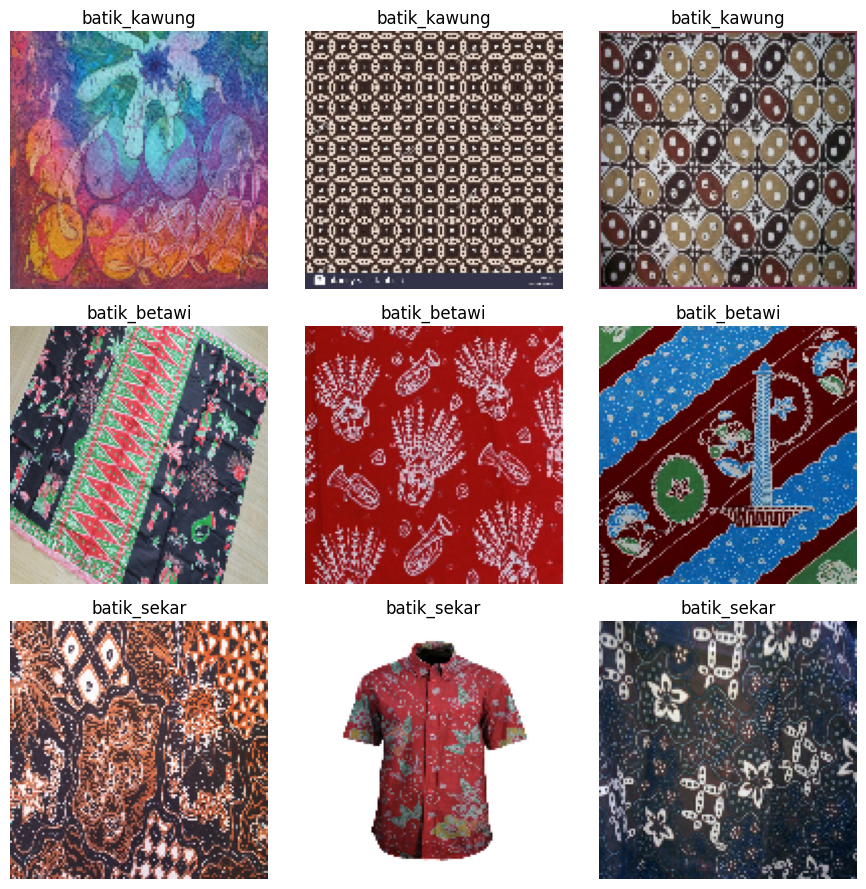

In [5]:
plt.figure(figsize=(9, 9))

# Display Batik kawung
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(batik_kawung[i][0])  
    plt.title("batik_kawung")  
    plt.axis('off')

# Display Batik bewati 
for i in range(3):
    plt.subplot(3, 3, i+4)
    plt.imshow(batik_betawi[i][0])  
    plt.title("batik_betawi")  
    plt.axis('off')

    
# Display Batik sekar
for i in range(3):
    plt.subplot(3, 3, i+7)
    plt.imshow(batik_sekar[i][0])  
    plt.title("batik_sekar")  
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Modelling

In [6]:
# Assuming your data is organized in one folder with subfolders for classes
data_dir = '/kaggle/input/indonesian-batik-motifs'

# Set image dimensions (adjust based on your pre-trained model)
img_width, img_height = 224, 224

# Define desired classes (modify based on your needs)
desired_classes = ['batik-sekar', 'batik-kawung', 'batik-betawi']

# Define number of classes (based on desired classes)
num_classes = len(desired_classes)

In [7]:
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) # TRAIN DATA GET AUGMENTED HERE
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Include only desired classes during data loading
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes,
    shuffle=False
)

Found 142 images belonging to 3 classes.
Found 142 images belonging to 3 classes.
Found 142 images belonging to 3 classes.


In [8]:
# Example usage
input_shape = (224, 224, 3)
num_classes = len(desired_classes)  # Change this to the number of classes in your dataset

# Scratch Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense

def ScratchModel(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Flatten and dense layers
    x = Flatten(name='flatten_layer')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_layer = Dense(num_classes, activation='softmax', name='output_layer')(x)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg16_custom')
    
    return model

In [10]:
scratch_model = ScratchModel(input_shape=input_shape, num_classes=num_classes)

# Compile the model
scratch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with early stopping
history_scratch = scratch_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=200,  # Set a high number of epochs since early stopping will handle the stopping
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718270293.566049     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718270293.593847     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3125 - loss: 1.3860

W0000 00:00:1718270338.521998     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3273 - loss: 1.4441 

W0000 00:00:1718270342.772475     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 17s/step - accuracy: 0.3346 - loss: 1.4415 - val_accuracy: 0.3594 - val_loss: 1.1137 - learning_rate: 0.0010
Epoch 2/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.2188 - loss: 1.1643

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718270346.750270     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.2188 - loss: 1.1643 - val_accuracy: 0.2857 - val_loss: 1.1133 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2656 - loss: 1.1088 - val_accuracy: 0.3281 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2143 - loss: 1.1108 - val_accuracy: 0.2143 - val_loss: 1.1086 - learning_rate: 0.0010
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4197 - loss: 1.0945 - val_accuracy: 0.3438 - val_loss: 1.0980 - learning_rate: 0.0010
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.2188 - loss: 1.1189 - val_accuracy: 0.4286 - val_loss: 1.0967 - learning_rate: 0.0010
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3713 - loss: 1.0986 - val_accuracy: 0.3672 - val_loss: 1.0963 - learning_rate: 0.0010
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3125 - loss: 1.1030 - val_accuracy: 0.2143 - val_lo

# Convergence Checking 

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall

def plot_training_history(history):
    # Extract metrics
    history_dict = history.history

    # Plot layout
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Training and validation loss
    axs[0].plot(history_dict['loss'], label='Training Loss')
    axs[0].plot(history_dict['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Validation Loss')

    # Training and validation accuracy
    axs[1].plot(history_dict['accuracy'], label='Training Accuracy')
    axs[1].plot(history_dict['val_accuracy'], label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Training and Validation Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

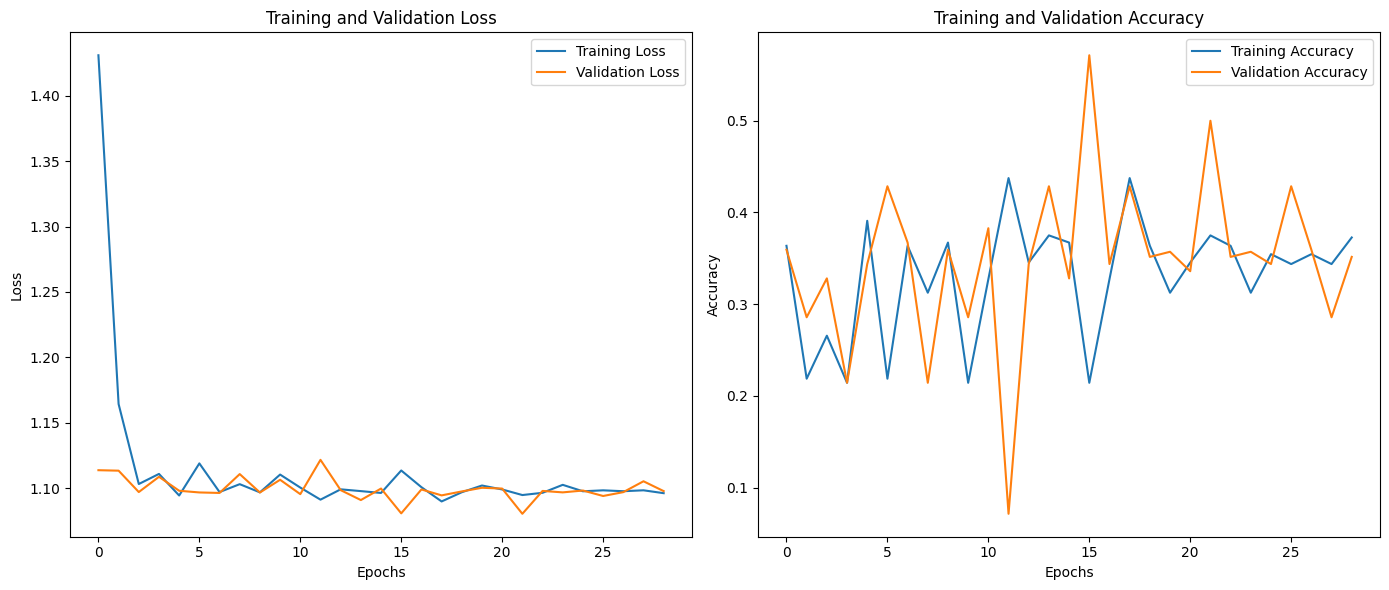

In [13]:
plot_training_history(history_scratch)

# EVALUATION FOR SCRATCH MODEL

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step
Classification Report:
              precision    recall  f1-score   support

 batik-sekar       0.00      0.00      0.00        47
batik-kawung       0.00      0.00      0.00        45
batik-betawi       0.35      1.00      0.52        50

    accuracy                           0.35       142
   macro avg       0.12      0.33      0.17       142
weighted avg       0.12      0.35      0.18       142



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


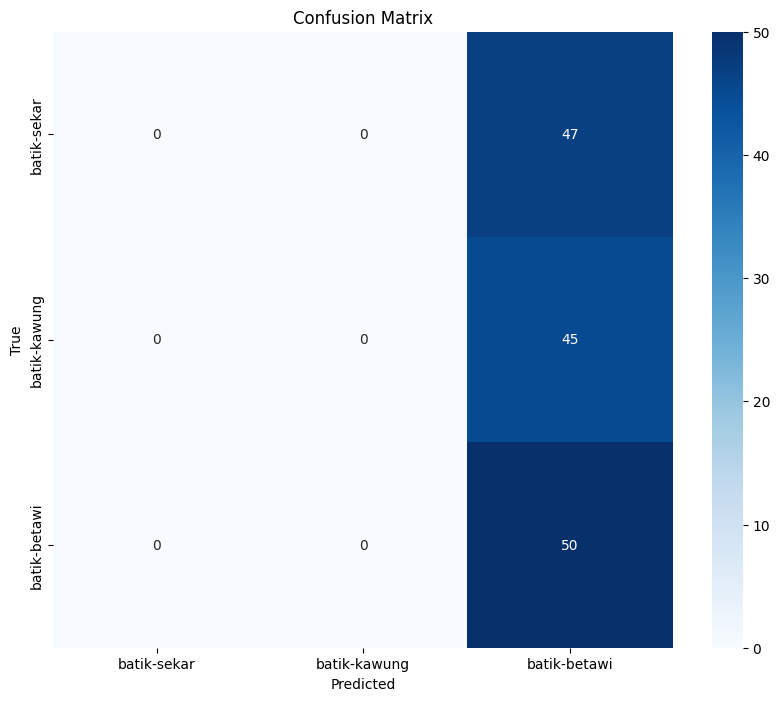

In [98]:
# Make predictions on the images using the generator
predictions = scratch_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from test_generator
y_true = test_generator.classes

# Print the classification report
report = classification_report(y_true, y_pred, target_names=desired_classes)
print('Classification Report:')
print(report)

 # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Pretrained Model with Parameter under 10M 

In [46]:

# Preprocess images using preprocess_input before passing to the model
preprocessed_images = []
for images, labels in test_generator:
    preprocessed_images.append(preprocess_input(images))
    if len(preprocessed_images) * 32 >= len(test_generator.filenames):
        break

# Concatenate preprocessed images and labels
preprocessed_images = np.concatenate(preprocessed_images)
test_labels = test_generator.classes

In [94]:
# from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 pretrained on ImageNet
under10M = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Choose how many top layers to fine-tune (e.g., last 10)
for layer in under10M.layers[:-8]:
  layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(under10M.output)
x = Dense(128, activation='relu')(x)  # Optional additional dense layer
predictions = Dense(3, activation='softmax')(x)  # 3 units for 3 classes, softmax for multi-class classification

# Create the model
newUnder10M = Model(inputs=under10M.input, outputs=predictions)

# Compile the model
newUnder10M.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluations for UNDER 10 M MODEL

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Classification Report:
              precision    recall  f1-score   support

 batik-sekar       0.00      0.00      0.00        47
batik-kawung       0.32      1.00      0.48        45
batik-betawi       0.00      0.00      0.00        50

    accuracy                           0.32       142
   macro avg       0.11      0.33      0.16       142
weighted avg       0.10      0.32      0.15       142



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


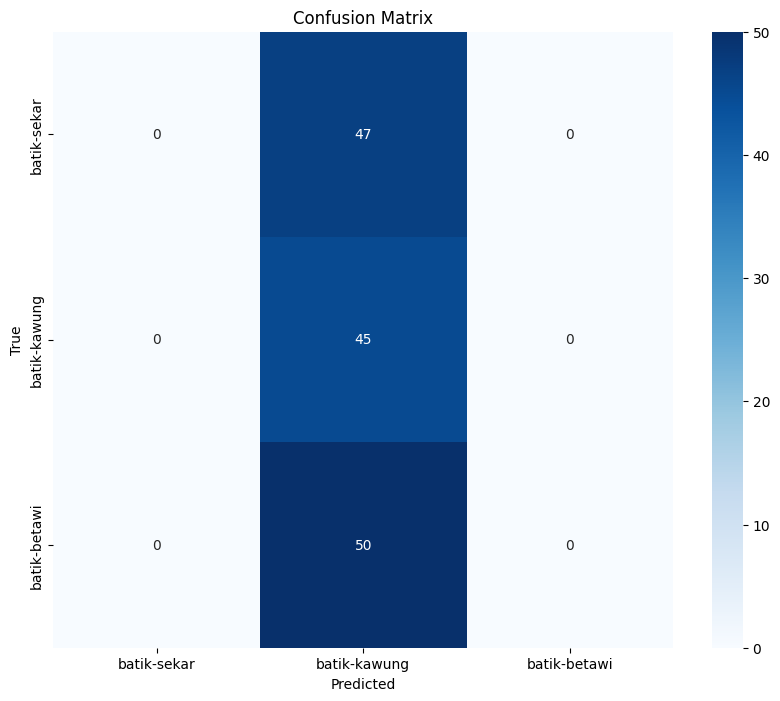

In [95]:
# Make predictions on the images using the generator
predictions = newUnder10M.predict(preprocessed_images, steps=len(preprocessed_images), verbose=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from test_generator
y_true = test_generator.classes

# Print the classification report
report = classification_report(y_true, y_pred, target_names=desired_classes)
print('Classification Report:')
print(report)

 # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()